In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_probability as tfp

from tensorflow.keras.regularizers import L2,L1

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns


In [2]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

In [3]:
def split(dataset, TRAIN_RATIO = 0.8, VAL_RATIO=0.1, TEST_RATIO=0.1):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [4]:
train_dataset, val_dataset, test_dataset = split(dataset[0])
print(list(train_dataset.take(1).as_numpy_iterator())
      , list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

### Visualization 

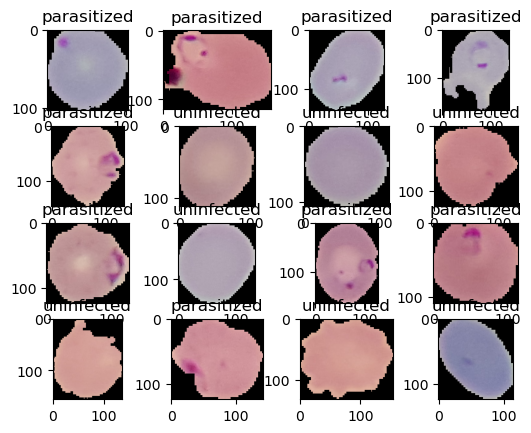

In [5]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))

### Data Processing

#### Data Augmentation

In [6]:
def visualize (original, augmented):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(original))
    
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(augmented))

In [7]:
original_image, label = next(iter(train_dataset))

In [8]:
augmented_image = tf.image.flip_left_right(original_image)

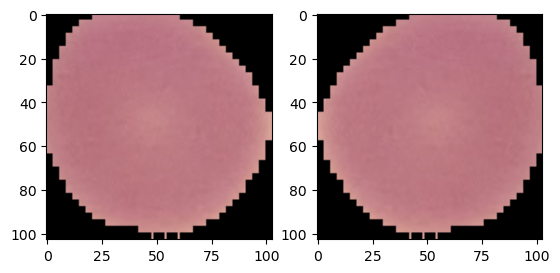

In [9]:
visualize(original_image, augmented_image)

In [10]:
IM_SIZE = 224
def resize_rescale(image,label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0 , label

In [11]:
#tf.kears.layer.resizing and scaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255.0),
])

In [12]:
### tf.image augmentation
def augment(image, label):
    
    image, label = resize_rescale(image,label)
    
    image = tf.image.rot90(image, k = tf.random.uniform(shape=[], minval = 0, maxval=2, dtype=tf.int32))
#     image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
#     image = tf.image.stateless_random_saturation(image, 0.3,0.5)
    image = tf.image.stateless_random_flip_left_right(image)
    
    return image, label

In [13]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, image):
        return tf.image.rot90(image,  k = tf.random.uniform(shape=[], minval = 0, maxval=2, dtype=tf.int32))

In [14]:
### tf.keras.layer augment

augment_layers = tf.keras.Sequential([
    RandomRotation(factor =(0.25,0.2501), ),
#     RotNinety(),
    RandomFlip(mode = 'horizontal',),
    RandomContrast(factor = 0.1),
])

def augment_layer(image,label):
#     image, label = resize_rescale(image,label)
    return augment_layers(resize_rescale_layers(image),training = True), label

In [15]:
# train_dataset = train_dataset.map(resize_rescale)
# val_dataset = val_dataset.map(resize_rescale)
# test_dataset = test_dataset.map(resize_rescale)

In [16]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
for image, label in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [18]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True)
#     .map(augment_layer)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True)
#     .map(augment_layer)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### Mixup Data Augmentation

In [33]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [46]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2,label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]

    image = lamda * image_1 + (1 - lamda)* image_2
    label = lamda * tf.cast(label_1, dtype = tf.float32) + (1 - lamda)* tf.cast(label_2, dtype = tf.float32)
    
    return image, label

In [47]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True)
    .map(mixup)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [48]:
val_dataset = (
    val_dataset
    .map(resize_rescale)
    .batch(BATCH_SIZE)
)

### Model Creation

### Sequential API

In [291]:
dropout_rate = 0.2
regularization_rate = 0.01
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (None, None, 3)),
                             
                             resize_rescale_layers,
                             augment_layers,
    
                             Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', kernel_regularizer = L2(regularization_rate)),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),
                             Dropout(rate = dropout_rate),
    
                             Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', kernel_regularizer = L2(regularization_rate)),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Flatten(),
    
                             Dense(100, activation = "relu", kernel_regularizer = L2(regularization_rate)),
                             BatchNormalization(),
                             Dropout(rate = dropout_rate),
    
                             Dense(10, activation = "relu", kernel_regularizer = L2(regularization_rate)),
                             BatchNormalization(),
    
                             Dense(1, activation = "sigmoid"),   

])

lenet_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_33 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_62 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 111, 111, 6)     

### Functional API

In [14]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output =  MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()
                                        
                            

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [15]:
IM_SIZE - 224
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
    
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),                        
    MaxPool2D(pool_size = 2, strides = 2),
    
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])

feature_extractor_seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [16]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_extractor_seq_model(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                       

## Model Subclassing

In [17]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
        self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [18]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_sub_classed(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

## Model Class

In [19]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation = "relu")
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(1, activation = "sigmoid")
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation = "sigmoid")
        
    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)

        
        return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))

lenet_sub_classed.summary()




Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  101       
                                                                 
 batch_normalization_17 (Ba  multiple                  

## Custom dense layer

In [20]:
class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_feature_shape):
        self.w = self.add_weight(shape = (input_feature_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
        self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)
        
    def call(self, input_features):
            
        pre_output = tf.matmul(input_features, self.w) + self.b
            
            
        if self.activation == "relu":
            return tf.nn.relu(pre_output)
            
        elif self.activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
            
        else:
            return pre_output

In [21]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
                             Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Flatten(),
    
                             CustomDenseLayer(10, activation = "relu"),
                             BatchNormalization(),
    
                             CustomDenseLayer(10, activation = "relu"),
                             BatchNormalization(),
    
                             CustomDenseLayer(1, activation = "sigmoid"),   

])

lenet_custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

### Callbacks

In [22]:
class LossCallback(Callback):
    def on_epoch_end(self,epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
        
    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {}".format(batch + 1, logs))

In [23]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

In [24]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [25]:
def scheduler(epoch, lr):
  if epoch < 2:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [82]:
check_point = ModelCheckpoint(
    'checkpoints/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch',
)

In [83]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
)

### Model Training

In [292]:
metrics = [ TruePositives(name = 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'), 
          BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc') ]

In [295]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
             loss = BinaryCrossentropy(),
             metrics = metrics,)
                #metrics = RootMeanSquaredError()

In [296]:
history = lenet_model.fit(train_dataset, validation_data = val_dataset,  epochs = 5, verbose = 1, callbacks=[ check_point, csv_callback, scheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/5
22046/22046 [==============================] - 409s 18ms/step - loss: 0.6987 - tp: 5773.0000 - fp: 5754.0000 - tn: 5454.0000 - fn: 5459.0000 - accuracy: 0.5003 - precision: 0.5008 - recall: 0.5140 - auc: 0.4981 - val_loss: 0.6979 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1360.0000 - val_fn: 1395.0000 - val_accuracy: 0.4936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/5
22046/22046 [==============================] - 33699s 2s/step - loss: 0.6991 - tp: 5339.0000 - fp: 5374.0000 - tn: 5647.0000 - fn: 5686.0000 - accuracy: 0.4983 - precision: 0.4984 - recall: 0.4843 - auc: 0.4954 - val_loss: 0.6985 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1369.0000 - val_fn: 1386.0000 - val_accuracy: 0.4969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.50

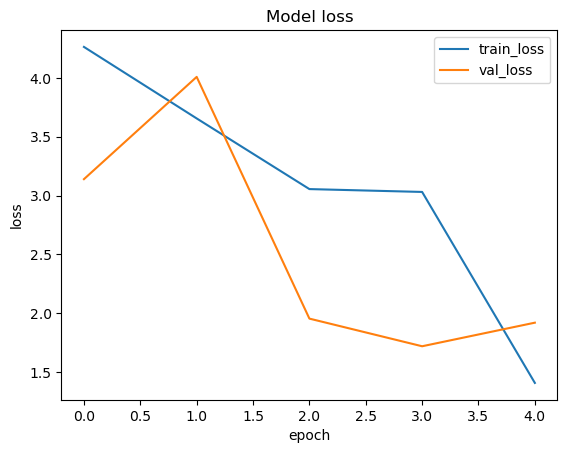

In [244]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

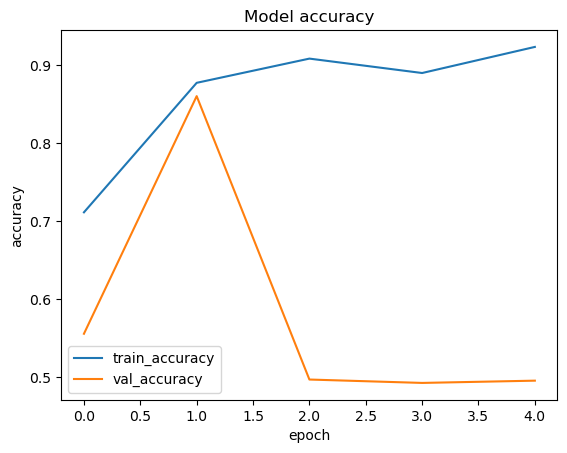

In [245]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Model Evaluation and Testing

In [218]:
test_dataset = test_dataset.batch(1)

In [219]:
lenet_custom_model.evaluate(test_dataset)

2757/2757 [==============================] - 8s 2ms/step - loss: 0.4468 - tp: 1345.0000 - fp: 291.0000 - tn: 1104.0000 - fn: 17.0000 - accuracy: 0.8883 - precision: 0.8221 - recall: 0.9875 - auc: 0.9492


[0.44678226113319397,
 1345.0,
 291.0,
 1104.0,
 17.0,
 0.8882843852043152,
 0.8221271634101868,
 0.9875183701515198,
 0.9492313265800476]

In [222]:
def parasite_or_not(x):
    if(x < 0.5):
        return str('P')
    else:
        return str('U')

In [223]:
parasite_or_not(lenet_model.predict(test_dataset.take(1)))

1/1 [==============================] - 1s 1s/step


'P'

1/1 [==============================] - 0s 9ms/step


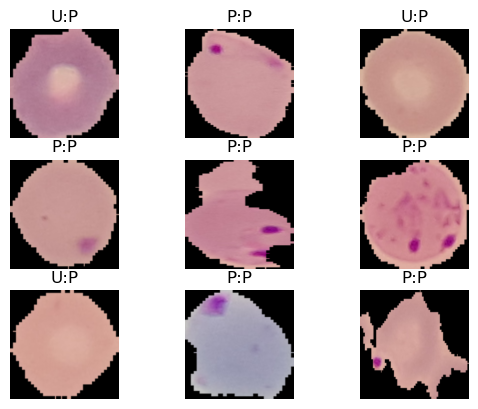

In [224]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    
    plt.axis('off')

Visualizing Confusion Matrix

In [235]:
labels = []

inp = []

for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [238]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [233]:
# print(labels)
labels = np.array([i[0] for i in labels])


In [234]:
print(labels)

[1 1 0 ... 0 1 1]


In [240]:
predicted = lenet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 [==============================] - 3s 27ms/step
[0.997726   0.00350764 0.99771506 ... 0.994579   0.98072207 0.99475837]


[[1103  289]
 [  17 1348]]


Text(0.5, 58.7222222222222, 'Predicted')

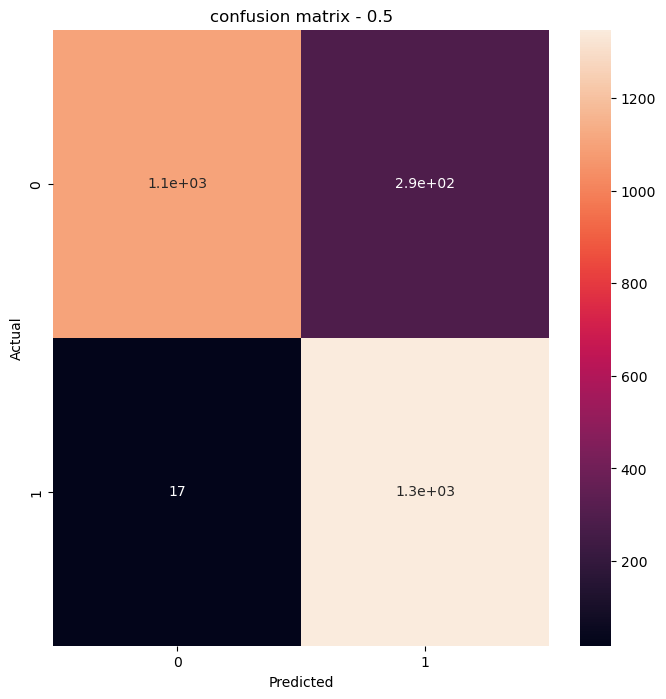

In [245]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)

print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True,)

plt.title('confusion matrix - {}'.format(threshold))

plt.ylabel('Actual')
plt.xlabel('Predicted')

ROC PLOT

422 422 422


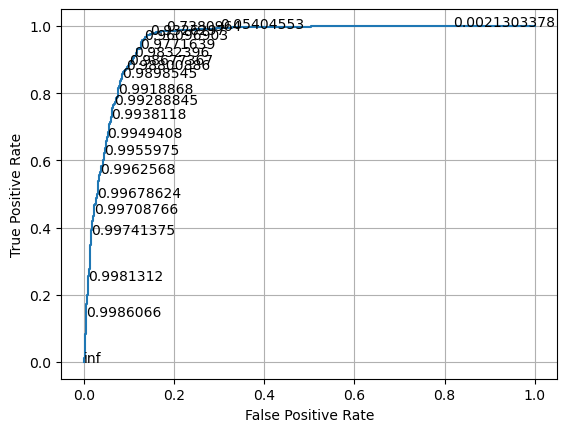

In [249]:
fp, tp, threshold = roc_curve(labels, predicted)
print(len(fp), len(tp), len(threshold))

plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()

skip = 20

for i in range(0, len(threshold), skip):
    plt.text(fp[i],tp[i], threshold[i])

plt.show()

TypeError: Invalid shape (32, 224, 224, 3) for image data

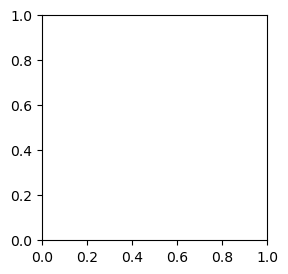

### Functional API

### Resnet Model